In [1]:
from models import FeedforwardNeuralNetModel, TinyCNN, PatternClassifier
import regularizer_losts as rl
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
import utils as CFI_utils
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
#from frozendict import frozendict
from datetime import datetime
import seaborn as sn
import pandas as pd
%matplotlib inline

import seaborn as sns
colors = sns.color_palette("tab10")

#Logging stuffs
import logging
import sys
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]


#configs
epochs = 10
batch_size = 1000
test_batch_size = 10000
stable_batch_size = 60000
use_cuda = True
lr = 0.01
log_interval = 100


#torch specific configs
torch.manual_seed(1)

device = torch.device("cuda")

train_kwargs = {'batch_size': batch_size}

test_kwargs = {'batch_size': test_batch_size}
stable_kwargs = {'batch_size': stable_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    stable_kwargs.update(cuda_kwargs)
class Shift:
    def __init__(self, shift = 0):
        print("alive")
        self.shift = shift

    def __call__(self, arr):
        print("running")
        #print(arr)
        return arr
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


transform = transforms.Compose([
    transforms.ToTensor(),
   
    transforms.Normalize((0.1307,), (0.3081,))
   
  
])

def shift_and_roll(arr : torch.Tensor, x : int , y : int) -> torch.Tensor:
    return torch.roll(arr, shifts = (x,y), dims = (0,1)) #indexing
def shift(arr : torch.Tensor, x : int , y : int) -> torch.Tensor:

    pad = [0,0,0,0]
    x_start = 0
    x_end = 0
    y_start = 0
    y_end = 0
    if x >= 0:
        pad[0] = x
        x_start = 0
        x_end = 28
    else:
         pad[1] = abs(x)
         x_start = -28
         
         
        
         
    
    if y >= 0:
        pad[2] = y
        y_start = 0
        y_end = 28
    else:
        pad[3] = abs(y)
        y_start= -28
        print("ys is {}".format(y_start))
    

    padder = torch.nn.ZeroPad2d(tuple(pad))
  
    result = padder(arr)

    if y < 0:
        y_end = result.shape[0]
    if x < 0:
        x_end = result.shape[1]
    
    return result[y_start:y_end, x_start:x_end]

def noisify(arr : torch.Tensor , distribution : torch.distributions.Distribution) -> torch.Tensor: #randomly add noise
   
    #print(distribution.sample(arr.size()).shape\\)
    #print(torch.reshape(distribution.sample(arr.size()), (28,28)).shape)
   
    noise = torch.reshape(distribution.sample(arr.size()), (arr.shape))
    return arr + noise
transform = transforms.Compose([
    transforms.ToTensor(),
   
    transforms.Normalize((0.1307,), (0.3081,))
])



In [2]:
def transform_dataset(dataset):
    '''
    DO A STATE CHANGE
    '''
    shift_x = 1
    shift_y = 0
    mu = 1
    sigma = 1
    do_shift = False
    do_noisfy = True
    modification_string = "base"
    if do_shift:
        modification_string += " -shift {} {} - ".format(shift_x, shift_y)
    if do_noisfy:
        modification_string += " -noise added using gaussian using mean {} and stddev {}- ".format(mu, sigma)
    for i in range(dataset.data.shape[0]):
        if do_shift:
            dataset.data[i,:,:] = shift(dataset.data[i,:,:],shift_x, shift_y)
        
        if do_noisfy:
            gaussian = torch.distributions.Normal(loc = mu, scale = sigma)# loc = mu, scale = stddev

            dataset.data[i,:,:] = noisify(dataset.data[i,:,:], gaussian)
    return modification_string

## Agenda
### Big question: CFI for NN


Are we doing complete verification or fuzzing/testing?

What is a `CFI`?

# What is a good abstraction for a NN's structure? Can it be enforced through regularization?
- Distillation? (https://arxiv.org/pdf/1503.02531.pdf)
- Decision Tree? (https://arxiv.org/pdf/1711.09784.pdf)
- Model Extraction? (https://arxiv.org/pdf/2003.04884.pdf)


### Where are we?
We want to do CFI for NN

## Question: Do we want to verify each AP separately? Or we want to tell the difference between activation patterns of real images from fake one using a method M and verify M?



## Option 1: We want to verify each AP separately (we are here)
To be able to do so, we need

### Condition 1: The number of activation patterns for a neural networks has to be way smaller than the size of the training/test set.
#### Why: 

  If every input results in a different AP, given an AP, very likely during infer time every input will have its own AP, so we have to reject it

  We want to verify each AP separately, so smaller the number the better

#### Progress: 

  with the current regularization effort, we have been able to reduce the number of AP to about 20k for 60k input.

#### Aim: 

Reduce to about few hundreds

#### Tricky part: 

Given a network of N layers, we can limit the number of activation patterns by only looking at k < N layers. Question: which k? 

### Condition 2: All, or most, of the activation patterns of the test set has to be covered by the AP of the training set
#### Why: 
If the activation patterns in the test set are completely different from the training set, there would be too many false negative at the inferencing time
#### Progress: 
Possible, but with a big caveat: the fake AP is now also included in the set

### Condition 3: Given an adv exp, its AP cannot be in the training AP set.
#### Progress:
Currently, if Cond.2 is satisfied, then 3 is not.


## Option 2: Train the network s.t the fake AP and real AP can be separated by some methods (linear classifier or a small neural net)

## What are the state-of-the-art attacks and defences?


## Backlog RQs: 
- BRQ1: Can we look at a random k entries in the weight instead of the first k?
- BRQ2: What if we set all the small abs weight in the Pattern classifer to 0? what is the accuracy in that case?
- BRQ4: Given a simple attacking method (e.g, Fast gradient sign), build a dataset of activation maps of true and fake digits. Try to train a pattern classifier using that dataset.
- __BRQ5: Given a target and its corresponding adv. exp, can we gradually move in the in-between space to see at which point the label is changed?__




In [3]:
def check_gradient(grad, label, last_sorted_grads, plot = False):
    logging.info("CHECKING GRADIENT FOR LABEL {}".format(label))
    sum_abs_grad = np.sum(abs(grad[label]), axis = 0)
    
    current_sorted_grad = (-sum_abs_grad).argsort()
    
#     if len(last_sorted_grads[label]) > 0:
#         for k in [100, 200, 300, 400]:
#             prev_top_k = set(last_sorted_grads[label][-1][:k])
#             current_top_k = set(current_sorted_grad[:k])
#             intersect = prev_top_k.intersection(current_top_k)
#             logging.info('k = {}. How many top Gradients are stable since last epoch?: {}'.format(k, len(intersect)))
        
    for k in [0, 9, 99, 199]:    
        logging.debug('{}th biggest gradient = {}'.format(k, np.sort(-sum_abs_grad)[k]))
    if plot:
        fig = plt.figure(figsize=(30, 1))
        plt.bar(range(sum_abs_grad.shape[0]), sum_abs_grad)
        plt.show()
        print(sum_abs_grad.max(), sum_abs_grad.argmax(), sum_abs_grad.min())

    return current_sorted_grad



#init stuffs
LOAD = True
# LOADPATH = 'TinyCNNreg.conv1.conv2.fc1.fc2.17:09:00'
# LOADPATH = 'FFN18:28:21'
LOADPATH = 'FFN18_28_21'
# LOADPATH = 'TinyCNNreg.fc1.fc2.16:06:26'
LAST_N_EPOCHS = 10

dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)


#transform_dataset(dataset1)
#modification_string = transform_dataset(dataset2)
modification_string = ""
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
# model = TinyCNN().to(device)
if LOAD:
    model.load_state_dict(torch.load(LOADPATH))
else:

    epochs = 10
    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)
    last_sorted_grads = defaultdict(list)
    
    all_rows = []
    
    for epoch in tqdm(range(1, epochs + 1)):
        model.register_gradient()
        model.train()
        target_log  = None # need to record the label to match with the gradient later
        for data, target in train_loader:
            target_log = np.concatenate((target_log, target), axis = 0) if target_log is not None else target
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data.float())
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        CFI_utils.test(model, device, test_loader)
#         scheduler.step()
        grad = CFI_utils.get_grad_each_label(model.gradient_log, 
                                      target_log = target_log, 
                                      layers = ['fc1', 'fc2', 'fc3', 'fc4'], 
                                      labels = range(10))
        torch.save(model.state_dict(), model.model_savename())
        
        row_data = []
        for label in range(10):
            r = []
            logging.info("After {} epoch:".format(epoch))
            last_sorted_grads[label].append(check_gradient(grad, label, last_sorted_grads))
            
            
            if epoch >= LAST_N_EPOCHS:
                for k in [100, 200, 300, 400]:
                    all_top_k = [set(sorted_grad[:k]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
                    intersect = set.intersection(*all_top_k)
                    logging.info('k = {}. How many top Gradients are stable among all last {} epochs?: {}'.format(k, LAST_N_EPOCHS, len(intersect)))
with torch.no_grad():
    total = 0
    correct = 0
    for data, target in dataset2:
        if int(torch.argmax(model.cuda()(data.cuda()), dim = 1)) == target:
            correct += 1
        total+=1
    "accuracy {}".format( correct/total)
    modification_string += " -accuracy {}-".format( correct/total)
    print(modification_string)

 -accuracy 0.9042-


# Study stable gradients

## Compute all patterns in the training set, and put them into corresponding labels

In [4]:
class Patterns:
    def __init__(self, model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, labels, layers):
        self._model = model
        self.label2patterns = {}
        self.label2idx = {}
        self._labels = labels
        self._layers = layers
        self._dataloader = dataloader
        self._populate()
        
    def _populate(self):
        
        label2patterns = {}
        label2idx = {}
        for label in self._labels:
            patterns = []
            filter_ids = []
            
            for data, target in self._dataloader:
                
                flter = np.where(target == label)
                filter_ids.append(flter)
                data = data[flter]
                logging.debug(data.shape[0])
                pattern = self._model.get_pattern(data, layers, device, flatten = True)
                logging.debug(pattern.shape)
                patterns.append(pattern)

            patterns = np.squeeze(np.concatenate(patterns, axis = 0))
            filter_ids = np.squeeze(np.concatenate(filter_ids, axis = 0))
            label2patterns[label] = patterns
            label2idx[label] = filter_ids
            
            logging.info(patterns.shape)
        
        #freeze
        self.label2patterns = dict(label2patterns)
        self.label2idx = dict(label2idx)
        
    def apply_filter(self, f):
        pass
    
    def unique():
        pass
    
    def query_pattern():
        pass


layers = ['fc1', 'fc2', 'fc3', 'fc4']
labels = range(10)
K = 25
stable_loader = torch.utils.data.DataLoader(dataset1, **stable_kwargs)

all_patterns = Patterns(model = model,
                        dataloader = stable_loader,
                        labels = labels,
                        layers = layers)
all_test_patterns = Patterns(model = model,
                        dataloader = test_loader,
                        labels = labels,
                        layers = layers)

root - INFO - (5923, 458)
root - INFO - (6742, 458)
root - INFO - (5958, 458)
root - INFO - (6131, 458)
root - INFO - (5842, 458)
root - INFO - (5421, 458)
root - INFO - (5918, 458)
root - INFO - (6265, 458)
root - INFO - (5851, 458)
root - INFO - (5949, 458)
root - INFO - (980, 458)
root - INFO - (1135, 458)
root - INFO - (1032, 458)
root - INFO - (1010, 458)
root - INFO - (982, 458)
root - INFO - (892, 458)
root - INFO - (958, 458)
root - INFO - (1028, 458)
root - INFO - (974, 458)
root - INFO - (1009, 458)


In [5]:
all_patterns.label2idx[0].shape

(5923,)

In [6]:
#we can only study gradient if the model is trained
# FIXME: should save gradient into a pickle as well
if not LOAD:
    for K in [25, 50, 100]:
        print("K=", K)
        row = []
        row.append(str(K))
        for label in labels:
            #construct the stable gradients 
            all_top_k = [set(sorted_grad[:K]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
            intersect = set.intersection(*all_top_k)
            stable_grad = np.array(sorted(list(intersect)))
            print("There are {} stable grad in top K".format(len(stable_grad)))
            print(stable_grad)

            logging.info(all_patterns[label].shape)
            print("LABEL:", label)
            print("how many unique paths in the full pattern?", np.unique(all_patterns[label], axis = 0).shape)
            print("how many unique paths in the filtered pattern?", np.unique(all_patterns[label][:, stable_grad ], axis = 0).shape)
            print("how many unique paths in the randomly filtered pattern?", 
                  np.unique(patterns[:, 
                                     np.random.choice(458, len(stable_grad), replace = False) ], axis = 0).shape)
            row.append("|".join([str(len(stable_grad)),
                                 str(np.unique(all_patterns[label], axis = 0).shape[0]),
                                 str(np.unique(all_patterns[label][:, stable_grad ], axis = 0).shape[0]),
                                 str(np.unique(all_patterns[label][:, np.random.choice(458, len(stable_grad), replace = False) ], axis = 0).shape[0])
                                ]))
        all_rows.append(",".join(row)+"\n")

    with open("gradient_exp_log_2.csv", "w") as f:
        f.write("K,"+",".join([str(l) for l in labels]) + "\n")
        f.writelines(all_rows)

                   

# Study stable ReLUs

In [7]:
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.bool_):
            return int(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)
    


all_stable_relus = []

all_alpha_patterns = {"model": LOADPATH}

write_log = True
if write_log:
    ReLU_exp_log = open("relu_exp_log{}.csv".format(datetime.now().strftime("%H-%M-%S")), "w")
    ReLU_exp_json = open("relu_exp_data{}.json".format(datetime.now().strftime("%H-%M-%S")), "w")
    ReLU_exp_log.write("Epsilon,Label,NumStableReLU,NumUniqueAP,Alpha Pattern Cover\n")



# for epsilon in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]:
epsilon_to_patterns = dict()
for epsilon in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]:
    alpha_patterns = {}
    label_to_most_common_pattern = dict()
    for label in all_patterns.label2patterns:
#     for label in [0,2,8]:
        patterns = all_patterns.label2patterns[label]
        print(patterns.shape)

        occuring_patterns = patterns.tolist() #make patterns into list of lists first dim is each example, second dim is the pattern
        most_common_pattern = max(occuring_patterns, key =  lambda x :occuring_patterns.count(x)) #argmax the count of each pattern

        #print("most common pattern: {}".format(most_common_pattern) )
        
        pattern_indices = list(filter( lambda x : most_common_pattern[x] , range(len(most_common_pattern))   ))#get true indices     
        #print("pattern_indices: {}".format(pattern_indices))
        label_to_most_common_pattern[label] = (pattern_indices,most_common_pattern)
        relu_sum = np.sum(patterns, axis = 0).squeeze()
        
        print("threshold: ", epsilon*patterns.shape[0], (1-epsilon)*patterns.shape[0])
        
#         print("relu_sum, layer-1 ", relu_sum[:256])
#         print("relu_sum, layer-2 ", relu_sum[256:384])
#         print("relu_sum, layer-3 ", relu_sum[384:448])
        print("relu_sum, prediction", relu_sum[448:458])
#         print("relu_sum", relu_sum[-10:])
        
        non_active_neurons = np.where(relu_sum<=epsilon*patterns.shape[0])
        active_neurons = np.where(relu_sum>=(1-epsilon)*patterns.shape[0])
        print("non active neurons: ", non_active_neurons)
        print("active neurons: ", active_neurons)

        stable_idx = np.concatenate([np.where(relu_sum<=epsilon*patterns.shape[0]), 
                                     np.where(relu_sum>=(1-epsilon)*patterns.shape[0])],
                                    axis = 1
                                    ).squeeze()
        neuro_idx = patterns.shape[1] - 10 + label
        if neuro_idx not in stable_idx:
            print(f"WARN: neuro_idx = {neuro_idx} for label {label} is not stable, let's include it anyway")
            stable_idx = np.append(stable_idx, neuro_idx)
        stable_idx = sorted(stable_idx) #sort the indices of the stable ReLUs. 
        unique_patterns, freq = np.unique(patterns[:, stable_idx ], axis = 0, return_counts=True)
        alpha_p = unique_patterns[np.argmax(freq)]
        print()
        print("Label is ", label)
        print("Stable ReLUs", stable_idx)
        print("how many unique paths in the filtered pattern?", unique_patterns.shape)
        print("their freq\n", freq, freq.shape)
#         print("most prominent pattern", np.argmax(freq), alpha_p)
#         print("alpha_p is ", alpha_p)


        assert(len(stable_idx) == alpha_p.shape[-1])
        assert(freq.shape[0]==unique_patterns.shape[0])
#         alpha_patterns[label] = (stable_idx, tuple(alpha_p))
        alpha_patterns[label] = {"stable_idx": stable_idx,
                                "alpha_pattern": alpha_p,
                                "alpha_pattern_coverage": freq.max()/freq.sum(),
                                "pattern_frequency": freq}
    
#         print("pattern frequency:", freq)
        print("primary pattern coverage: ", freq.max()/freq.sum(),)

        if write_log:
            ReLU_exp_log.write("{},{},{},{},{}\n".format(epsilon, label, len(stable_idx), unique_patterns.shape[0], freq.max()/freq.sum()))
    all_alpha_patterns[epsilon] = alpha_patterns
    epsilon_to_patterns[epsilon] = label_to_most_common_pattern
json.dump(epsilon_to_patterns, open("most_common_patterns{}.json".format(datetime.now().strftime("%H-%M-%S")), "w")) 
    
if write_log:
    ReLU_exp_log.close()
    json.dump(all_alpha_patterns, fp = ReLU_exp_json, indent=2, cls=NpEncoder)
    ReLU_exp_json.close()

(5923, 458)
threshold:  0.5923 5922.4077
relu_sum, prediction [5685    0   29   15   11   77   48   11   43    4]
non active neurons:  (array([257, 267, 288, 338, 343, 374, 375, 392, 401, 403, 414, 418, 449],
      dtype=int64),)
active neurons:  (array([ 19,  70, 142, 238, 258, 259, 260, 265, 275, 285, 287, 295, 302,
       307, 323, 329, 339, 340, 346, 347, 349, 352, 360, 365, 369, 380,
       396, 406, 417, 420, 423, 424, 426, 429, 434], dtype=int64),)
WARN: neuro_idx = 448 for label 0 is not stable, let's include it anyway

Label is  0
Stable ReLUs [19, 70, 142, 238, 257, 258, 259, 260, 265, 267, 275, 285, 287, 288, 295, 302, 307, 323, 329, 338, 339, 340, 343, 346, 347, 349, 352, 360, 365, 369, 374, 375, 380, 392, 396, 401, 403, 406, 414, 417, 418, 420, 423, 424, 426, 429, 434, 448, 449]
how many unique paths in the filtered pattern? (2, 49)
their freq
 [ 238 5685] (2,)
primary pattern coverage:  0.95981765996961
(6742, 458)
threshold:  0.6742 6741.3258000000005
relu_sum, predictio

In [ ]:
debug = True
if debug:
    alpha_patterns = all_alpha_patterns[0.0001]
    for l1 in range(0,10):
        p1 = set(alpha_patterns[l1]["stable_idx"])
        print(f"label {l1} contains {len(p1)} neurons and has the following overlaps with others:" )
        row = []
        for l2 in range(0,10):
            p2 = set(alpha_patterns[l2]["stable_idx"])
            row.append( len( p1 & p2 ) )
        print(row)            
        


label 0 contains 49 neurons and has the following overlaps with others:
[49, 21, 18, 22, 22, 24, 36, 21, 29, 22]
label 1 contains 79 neurons and has the following overlaps with others:
[21, 79, 28, 35, 28, 24, 41, 26, 41, 24]
label 2 contains 34 neurons and has the following overlaps with others:
[18, 28, 34, 24, 25, 18, 32, 17, 28, 21]
label 3 contains 41 neurons and has the following overlaps with others:
[22, 35, 24, 41, 24, 22, 33, 24, 35, 25]
label 4 contains 53 neurons and has the following overlaps with others:
[22, 28, 25, 24, 53, 20, 42, 22, 32, 29]
label 5 contains 32 neurons and has the following overlaps with others:
[24, 24, 18, 22, 20, 32, 27, 20, 25, 22]
label 6 contains 76 neurons and has the following overlaps with others:
[36, 41, 32, 33, 42, 27, 76, 26, 42, 32]
label 7 contains 44 neurons and has the following overlaps with others:
[21, 26, 17, 24, 22, 20, 26, 44, 26, 25]
label 8 contains 64 neurons and has the following overlaps with others:
[29, 41, 28, 35, 32, 25,

[19, 70, 142, 238, 257, 258, 259, 260, 265, 267, 275, 285, 287, 288, 295, 302, 307, 323, 329, 338, 339, 340, 343, 346, 347, 349, 352, 360, 365, 369, 374, 375, 380, 392, 396, 401, 403, 406, 414, 417, 418, 420, 423, 424, 426, 429, 434, 448, 449]
(True, True, True, True, False, True, True, True, True, False, True, True, True, False, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, False, False, True, False, True, False, False, True, False, True, False, True, True, True, True, True, True, True, False)
dict_values([238])


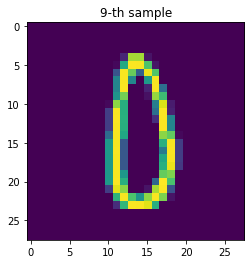

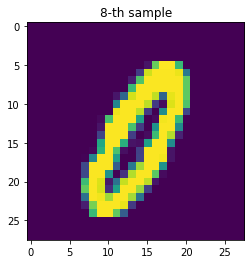

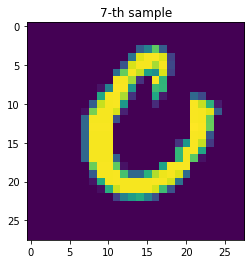

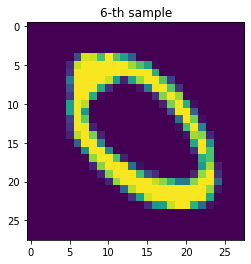

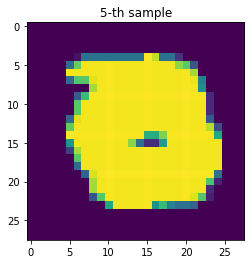

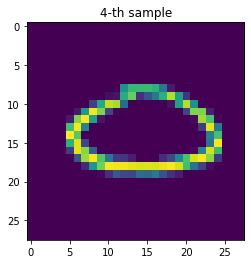

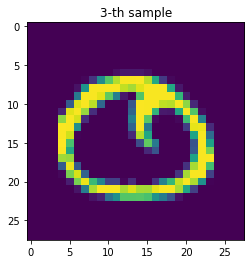

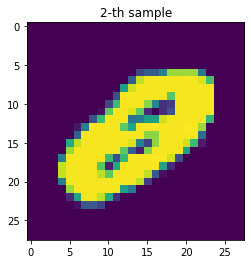

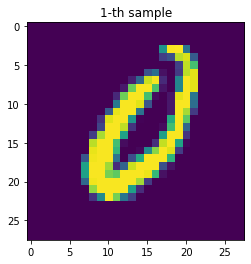

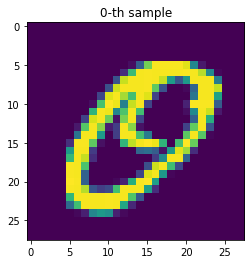

In [ ]:
#check
CHECK_WEIRD_IMAGE = True
image_samples = 10

if CHECK_WEIRD_IMAGE:
    label = 0
#     stable_idx, alpha_p = alpha_patterns[label]
    stable_idx = alpha_patterns[label]["stable_idx"]
    alpha_p = alpha_patterns[label]["alpha_pattern"]
    alpha_p = tuple(alpha_p)
    print(stable_idx)
    print(alpha_p)
    counters = defaultdict(int)
    for data, target in stable_loader:

        filter_ids = target == label

        data = data[filter_ids]
        pattern = model.get_pattern(data, layers, device)
        for idx, p in enumerate(pattern):
            filtered = tuple(p[stable_idx])
            if filtered != alpha_p:
                counters[filtered]+=1
                if image_samples > 0:
                    image_samples -= 1
                    fig = plt.figure()
                    plt.imshow(data[idx].reshape(28,28))
                    plt.title(f"{image_samples}-th sample")



    print(counters.values())

debug = False 
if debug: 
    label = 0
    stable_idx = alpha_patterns[label]["stable_idx"]
    alpha_p = alpha_patterns[label]["alpha_pattern"]
    alpha_p = tuple(alpha_p)
    print("stable_idx", stable_idx)
    print("alpha_p", alpha_p)
    counters = defaultdict(int)
    for data, target in test_loader:

        filter_ids = target == label

        data = data[filter_ids]
        pattern = model.get_pattern(data, layers, device)
        for idx, p in enumerate(pattern):
            filtered = tuple(p[stable_idx])
#             if filtered in intersection:
            if filtered != alpha_p:
                counters[filtered]+=1
    print(sum(counters.values()))

# RQ: 

In [ ]:
all_heatmaps = {}
# for epsilon in [0.01, 0.05]:
num_patterns = 1 #-1 for all
modification_string += " - num_patterns {} - ".format(num_patterns)
for epsilon in [0.0001]:    
    alpha_patterns = all_alpha_patterns[epsilon]
    heatmap = []
    for label in labels:
        row = []

        #compute the patterns that are both in train and test set
        stable_idx = np.array(alpha_patterns[label]["stable_idx"]) #for a label what are the stable relu, 1d array [10,20,50] are stable RELU
        p = model.get_pattern(some_input,layers, )
        print(p[stable_idx]) #only look at stable values, eacch is 0 or 1
        #confirm no overlap in stable region
        alpha_p = alpha_patterns[label]["alpha_pattern"]
        alpha_p = tuple(alpha_p)
        test_patterns = all_test_patterns.label2patterns[label]

        print("LABEL:", label)
        print("how many unique paths in the full pattern?", np.unique(test_patterns, axis = 0).shape)
        print("how many unique paths in the filtered pattern?", np.unique(test_patterns[:, stable_idx ], axis = 0).shape)
        print("how many unique paths in the randomly filtered pattern?", 
              np.unique(test_patterns[:, 
                                 np.random.choice(458, len(stable_idx), replace = False) ], axis = 0).shape)




        train_patterns = all_patterns.label2patterns[label]
        raw_train_patterns = np.unique(train_patterns[:, stable_idx], axis = 0)
        print(raw_train_patterns.shape)

        raw_test_patterns = np.unique(test_patterns[:, stable_idx], axis = 0)
        print(raw_test_patterns.shape)

        set_train_patterns = set([tuple(p) for p in raw_train_patterns])
        set_test_patterns = set([tuple(p) for p in raw_test_patterns])

        intersection = set_train_patterns.intersection(set_test_patterns)

        print(len(set_train_patterns), len(set_test_patterns))
        print(len(intersection))

        for label2 in labels:
            print(f"examining images with groundtruth label = {label2}")
            counters = defaultdict(int)
            img_ct = 0
            img_same_pattern = 0 
            for data, target in test_loader:

                filter_ids = target == label2

                data = data[filter_ids]
                pattern = model.get_pattern(data, layers, device)
                print(type(pattern))
                print(pattern)
                image_samples = 5
                for idx, p in enumerate(pattern):
                    print("p is {}".format(p))
                    img_ct += 1
                    filtered = tuple(p[stable_idx])
#                     if filtered in intersection:
#                         counters[filtered]+=1
                    if filtered == alpha_p:
                        img_same_pattern += 1
                        if image_samples > 0:
                            image_samples -= 1
                            fig = plt.figure()
                            plt.imshow(data[idx].reshape(28,28))
                            plt.title(f"gt-{label2}-s{image_samples} vs wrong:{label}")

#             row.append(sum(counters.values()))
            row.append(img_same_pattern)
            print(f"label2 = {label2} has {img_ct} images, out of which {img_same_pattern} share the same pattern as label={label}")
            
        heatmap.append(row)
    all_heatmaps[epsilon] = heatmap

NameError: name 'some_input' is not defined

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 1]]


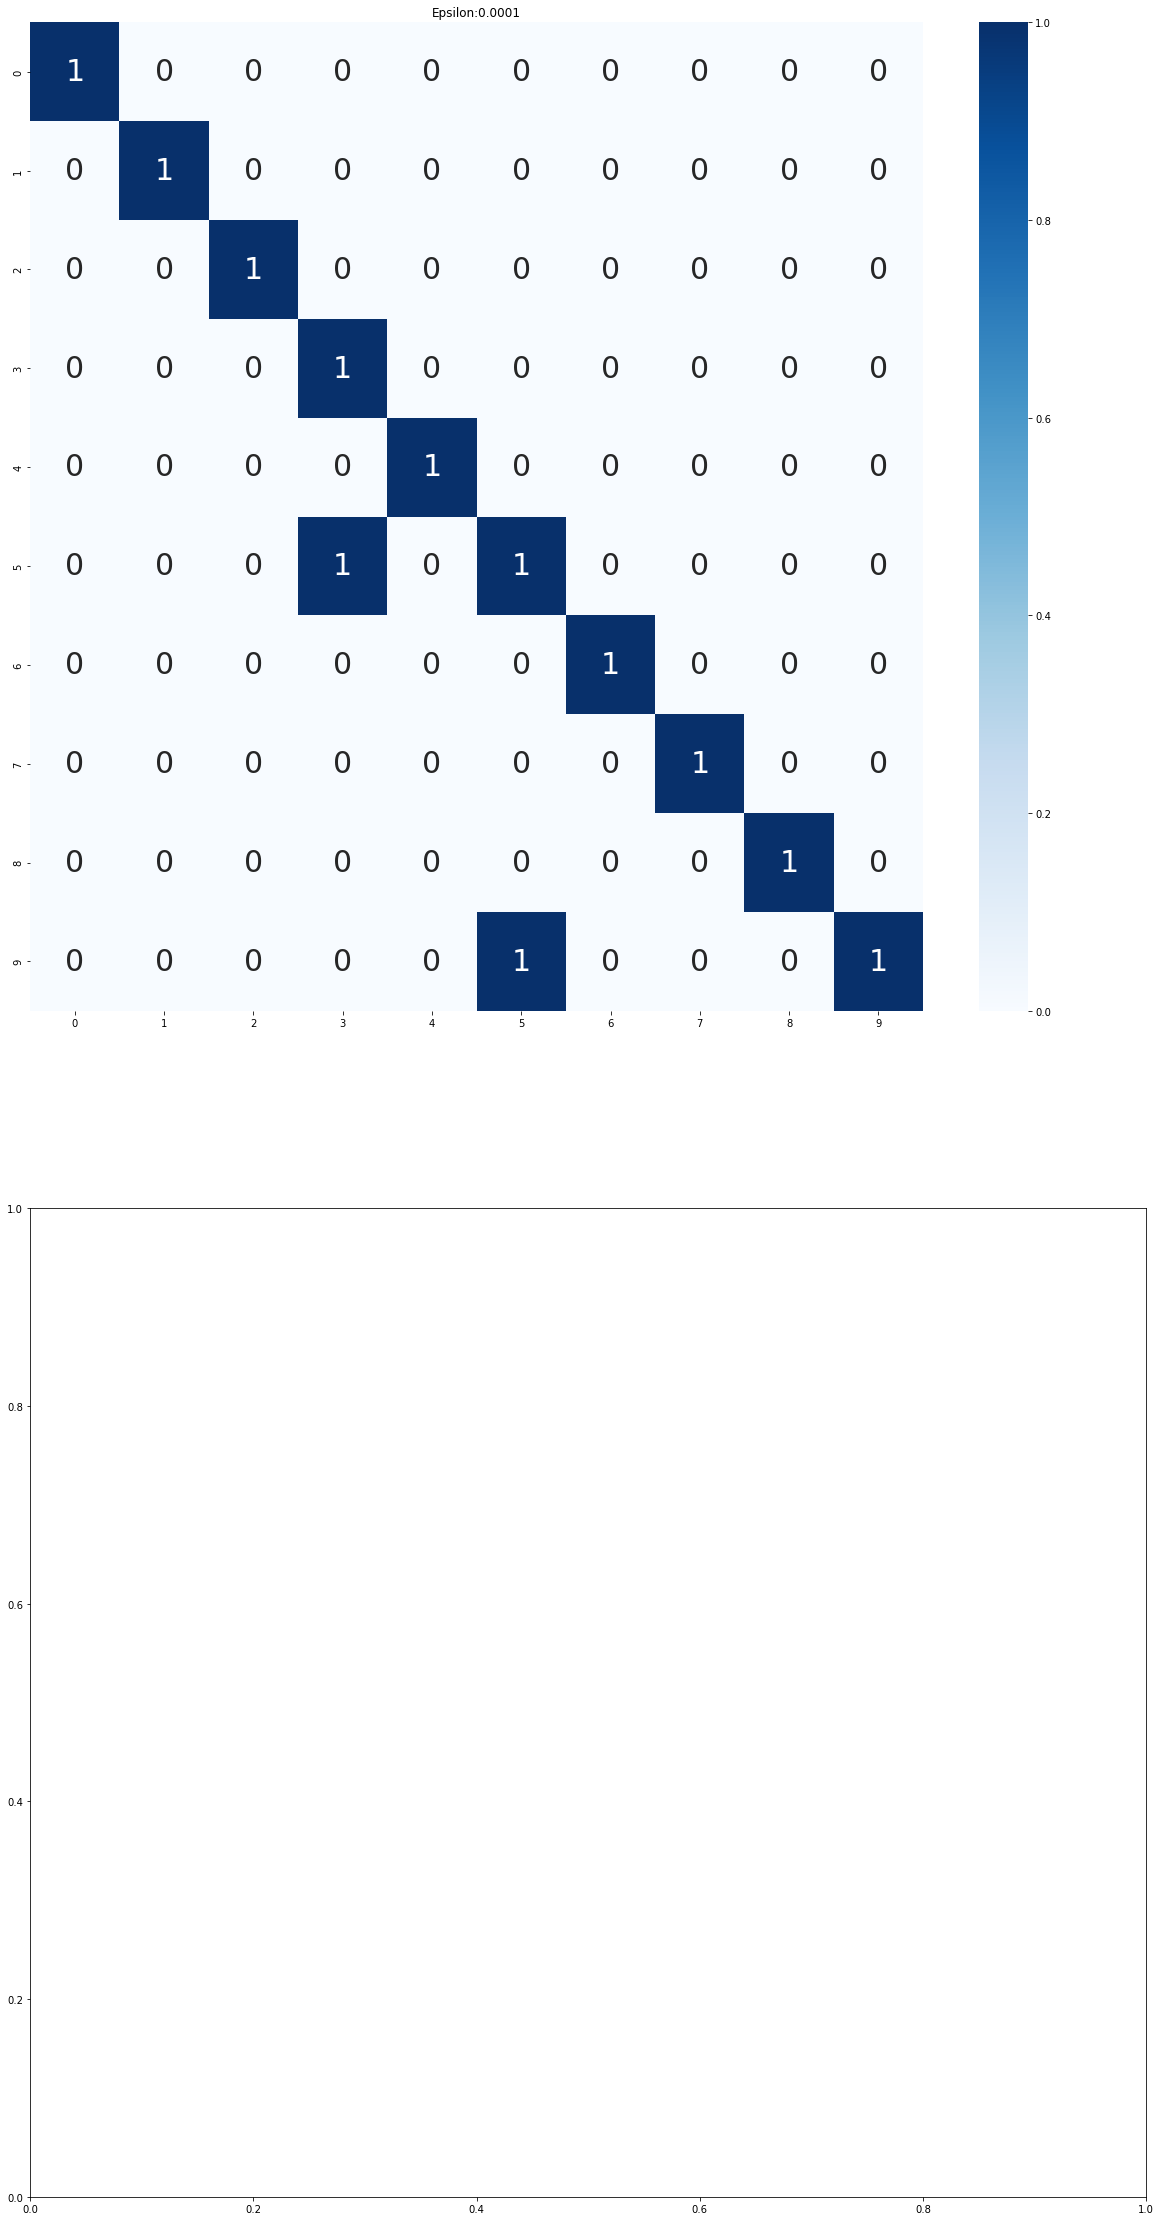

In [ ]:
"""
Test patterns
root - INFO - (980, 458)
root - INFO - (1135, 458)
root - INFO - (1032, 458)
root - INFO - (1010, 458)
root - INFO - (982, 458)
root - INFO - (892, 458)
root - INFO - (958, 458)
root - INFO - (1028, 458)
root - INFO - (974, 458)
root - INFO - (1009, 458)
"""
fig, axs = plt.subplots(nrows=2, figsize = (20, 40))
counter = 0
for epsilon in all_heatmaps:
    heatmap = all_heatmaps[epsilon]
    print(heatmap)
    df_cm = pd.DataFrame(heatmap, labels, labels)
    
    axs[counter].set_title("Epsilon:{}".format(epsilon))

    sn.heatmap( df_cm,ax = axs[counter], annot=True, cmap='Blues', fmt='g', annot_kws={"fontsize":30})
    counter+=1
fig.savefig(modification_string+'confusion_matrix{}.pdf'.format(datetime.now().strftime("%m-%d-%Y-%H-%M-%S")))
# print(intersection)

# RQ6:study the hot ReLU and the gradient
Do at least the following statistics on the activation patterns.
- What are the top k RELU with the highest gradient value (indicating that they are highly influential ReLU). If we only look at those ReLU, how many activation patterns do we have? This exp should be parametrized by k
- For activation patterns from images from the same label (e.g 7), what ReLU are stable, and what not? To check for stable, we set a threshold T%. If the value of the ith ReLU is the same for at least T% of the time, we say that ith ReLU is stable.
- Given that ith ReLU is stable for the label 7, is it also stable for a different label (e.g 9)? Note that for label 7, it may stable and always be 1, but for label 9, it may also be stable but with value 0.


#Checking ReLUs with highest gradient

